In [3]:
# %%
# Imports, seed, file checks, optional libs

import os
import sys
import random
import zipfile
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Optional plotting libs
try:
    import seaborn as sns
except Exception:
    sns = None

# Sklearn core
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

# Inspection
from sklearn.inspection import permutation_importance

# Optional ML libs
HAS_XGB = False
HAS_LGBM = False
HAS_CAT = False
HAS_SHAP = False
HAS_OPTUNA = False

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    xgb = None

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    lgb = None

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    CatBoostClassifier = None

try:
    import shap
    HAS_SHAP = True
except Exception:
    shap = None

try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    optuna = None

print("Optional libs:", {
    "xgboost": HAS_XGB,
    "lightgbm": HAS_LGBM,
    "catboost": HAS_CAT,
    "shap": HAS_SHAP,
    "optuna": HAS_OPTUNA
})

# File checks / unzip if needed
ROOT = Path(".").resolve()
train_path = ROOT / "train_c.csv"
test_path = ROOT / "test_c.csv"
ex_path = ROOT / "ex_c.csv"
zip_path = Path("/mnt/data/mai-ml-lab-2-fiit-2025.zip")

if (not train_path.exists()) or (not test_path.exists()) or (not ex_path.exists()):
    if zip_path.exists():
        print(f"CSV not found in {ROOT}. Extracting from: {zip_path}")
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(ROOT)
    else:
        raise FileNotFoundError(
            "Could not find train_c.csv/test_c.csv/ex_c.csv in current folder "
            "and no zip found at /mnt/data/mai-ml-lab-2-fiit-2025.zip"
        )

# Re-check
assert train_path.exists(), "train_c.csv not found"
assert test_path.exists(), "test_c.csv not found"
assert ex_path.exists(), "ex_c.csv not found"

print("Files OK:", train_path, test_path, ex_path)


Optional libs: {'xgboost': True, 'lightgbm': True, 'catboost': False, 'shap': True, 'optuna': False}
Files OK: /content/train_c.csv /content/test_c.csv /content/ex_c.csv


In [4]:
# %%
# Load data + basic checks

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
ex_df = pd.read_csv(ex_path)

print("train shape:", train_df.shape)
print("test shape :", test_df.shape)
print("ex shape   :", ex_df.shape)

print("\nTrain dtypes (head):")
display(train_df.dtypes.head(50))

print("\nTest dtypes (head):")
display(test_df.dtypes.head(50))

# Required columns checks
TARGET = "LoanApproved"
ID_COL = "ID"

assert TARGET in train_df.columns, "LoanApproved missing in train"
assert ID_COL not in train_df.columns, "train should NOT have ID"
assert ID_COL in test_df.columns, "test should have ID"
assert set(ex_df.columns) == {ID_COL, TARGET}, "ex_c.csv should have columns: ID, LoanApproved"

# Duplicates
train_dups = train_df.duplicated().sum()
test_dups = test_df.duplicated().sum()
print("\nDuplicates:", {"train": int(train_dups), "test": int(test_dups)})

# Missingness
miss_train = train_df.isna().sum().sort_values(ascending=False)
miss_test = test_df.isna().sum().sort_values(ascending=False)

print("\nTop missing in train:")
display(miss_train.head(20))

print("\nTop missing in test:")
display(miss_test.head(20))

# Target distribution (raw)
print("\nTarget value_counts (raw):")
display(train_df[TARGET].value_counts(dropna=False))

# Ensure target is binary 0/1 (stored as float)
y_raw = train_df[TARGET].copy()
# Convert float-ish to int (robust)
y = pd.to_numeric(y_raw, errors="coerce").fillna(0.0).round().clip(0, 1).astype(int).values
print("\nTarget after clean (0/1) value_counts:")
display(pd.Series(y).value_counts())

# Separate X
X = train_df.drop(columns=[TARGET]).copy()
X_test = test_df.copy()


train shape: (11017, 35)
test shape : (5000, 35)
ex shape   : (5000, 2)

Train dtypes (head):


,0
ApplicationDate,object
Age,float64
AnnualIncome,float64
CreditScore,float64
LoanAmount,float64
LoanDuration,float64
MaritalStatus,object
NumberOfDependents,float64
HomeOwnershipStatus,object
MonthlyDebtPayments,float64



Test dtypes (head):


,0
ID,int64
ApplicationDate,object
Age,int64
AnnualIncome,int64
CreditScore,int64
LoanAmount,int64
LoanDuration,int64
MaritalStatus,object
NumberOfDependents,int64
HomeOwnershipStatus,object



Duplicates: {'train': 1016, 'test': 0}

Top missing in train:


,0
MonthlyDebtPayments,1031
LoanAmount,1031
CreditScore,1031
BaseInterestRate,1031
NetWorth,1031
TotalAssets,1031
BankruptcyHistory,1031
LoanPurpose,1031
CheckingAccountBalance,1031
ApplicationDate,530



Top missing in test:


,0
ID,0
ApplicationDate,0
Age,0
AnnualIncome,0
CreditScore,0
LoanAmount,0
LoanDuration,0
MaritalStatus,0
NumberOfDependents,0
HomeOwnershipStatus,0



Target value_counts (raw):


,count
LoanApproved,
1.0,5367
0.0,5120
NaN,530



Target after clean (0/1) value_counts:


,count
0,5650
1,5367


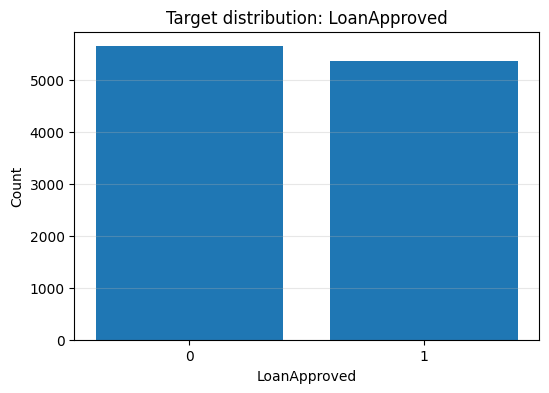

In [5]:
# %%
# EDA: target distribution

plt.figure(figsize=(6, 4))
vals, counts = np.unique(y, return_counts=True)
plt.bar(vals.astype(str), counts)
plt.title("Target distribution: LoanApproved")
plt.xlabel("LoanApproved")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


Key numeric columns used for plots: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MonthlyDebtPayments', 'DebtToIncomeRatio', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LengthOfCreditHistory', 'NetWorth']


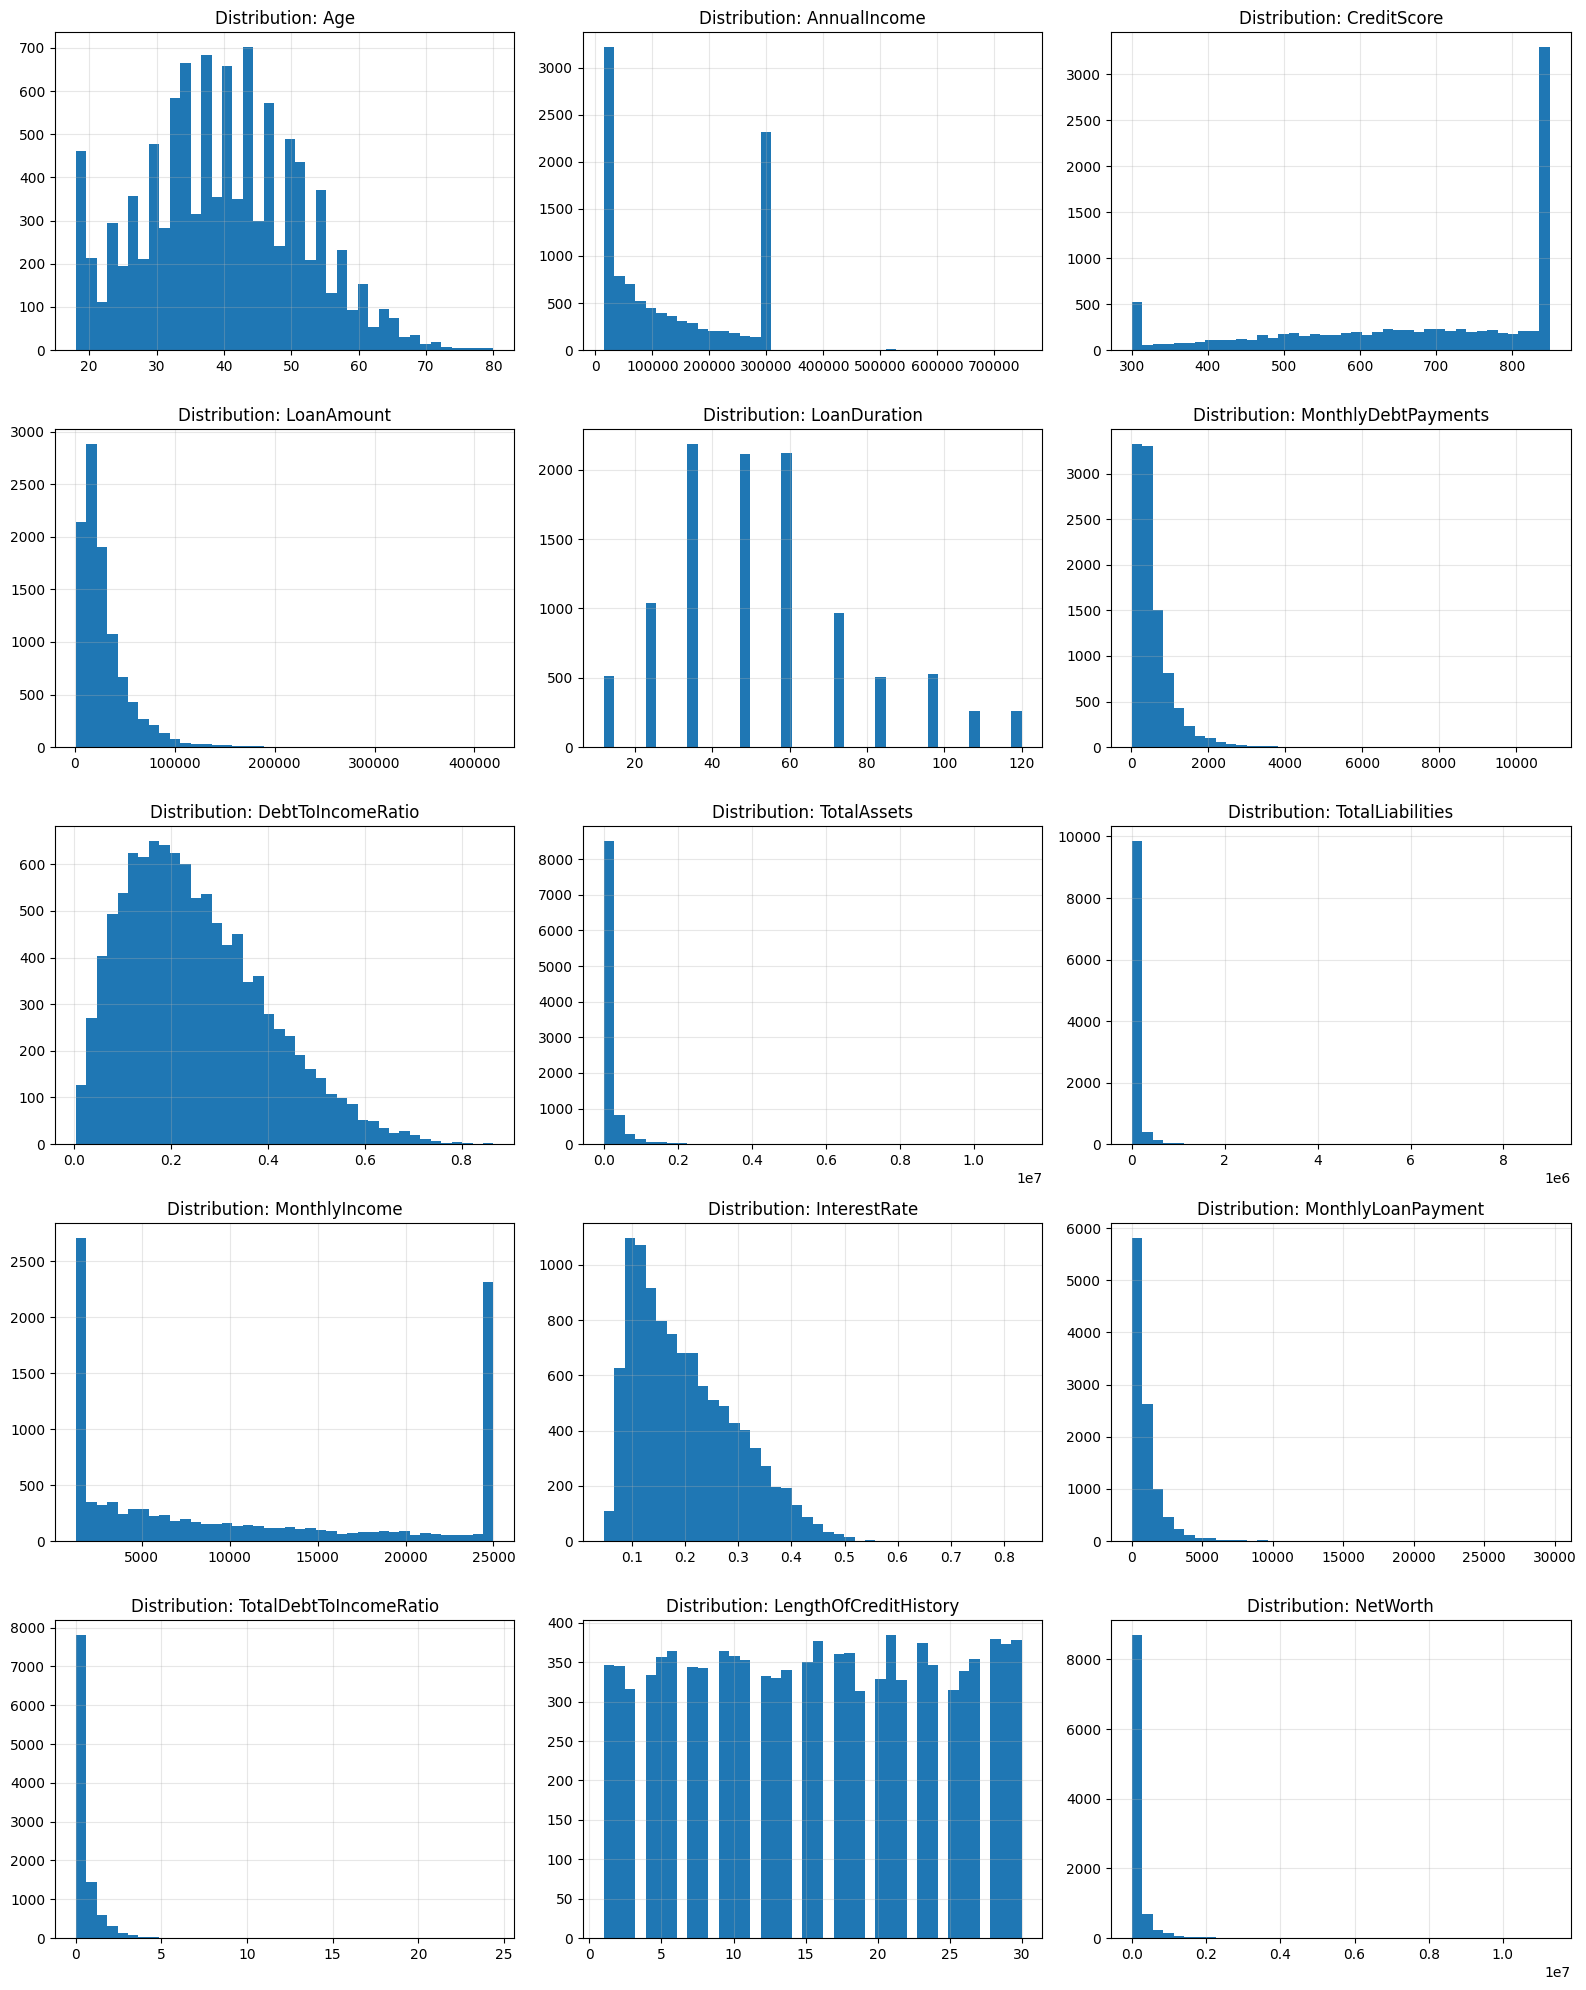

In [6]:
# %%
# EDA: key numeric distributions

# Identify categorical columns per spec
cat_cols = ["MaritalStatus", "HomeOwnershipStatus", "LoanPurpose", "EmploymentStatus", "EducationLevel"]
date_col = "ApplicationDate"

# Basic feature lists (before date FE)
all_cols = list(X.columns)
for c in cat_cols + [date_col]:
    if c not in all_cols:
        print(f"WARNING: expected column missing: {c}")

num_cols = [c for c in all_cols if c not in set(cat_cols + [date_col])]

# Choose some key numeric columns if present
key_numeric = [
    "Age", "AnnualIncome", "CreditScore", "LoanAmount", "LoanDuration",
    "MonthlyDebtPayments", "DebtToIncomeRatio", "TotalAssets", "TotalLiabilities",
    "MonthlyIncome", "InterestRate", "MonthlyLoanPayment", "TotalDebtToIncomeRatio",
    "LengthOfCreditHistory", "NetWorth"
]
key_numeric = [c for c in key_numeric if c in X.columns]
print("Key numeric columns used for plots:", key_numeric)

n_plots = len(key_numeric)
if n_plots > 0:
    ncols = 3
    nrows = int(np.ceil(n_plots / ncols))
    plt.figure(figsize=(16, 4 * nrows))
    for i, c in enumerate(key_numeric, 1):
        plt.subplot(nrows, ncols, i)
        data = pd.to_numeric(X[c], errors="coerce")
        plt.hist(data.dropna(), bins=40)
        plt.title(f"Distribution: {c}")
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


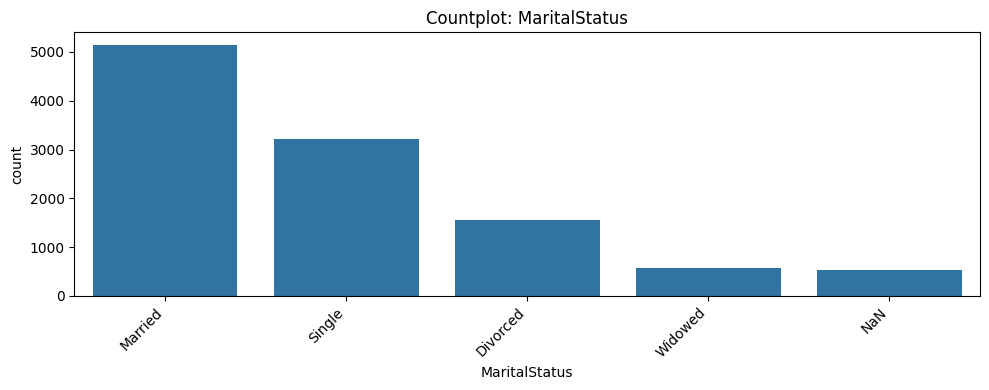

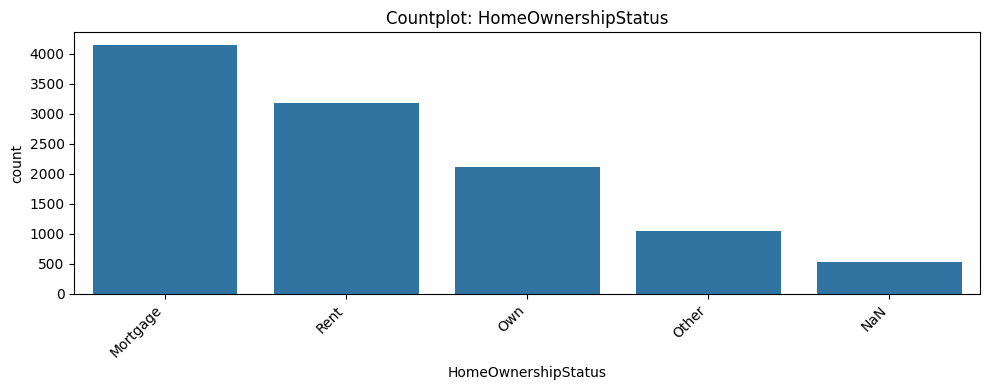

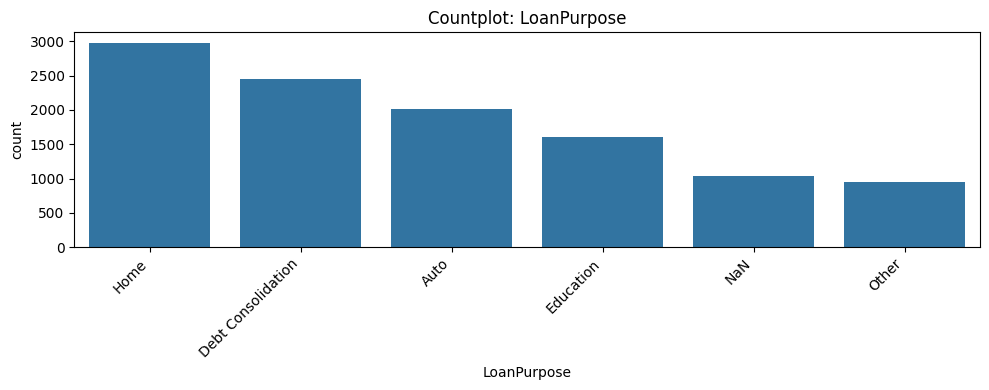

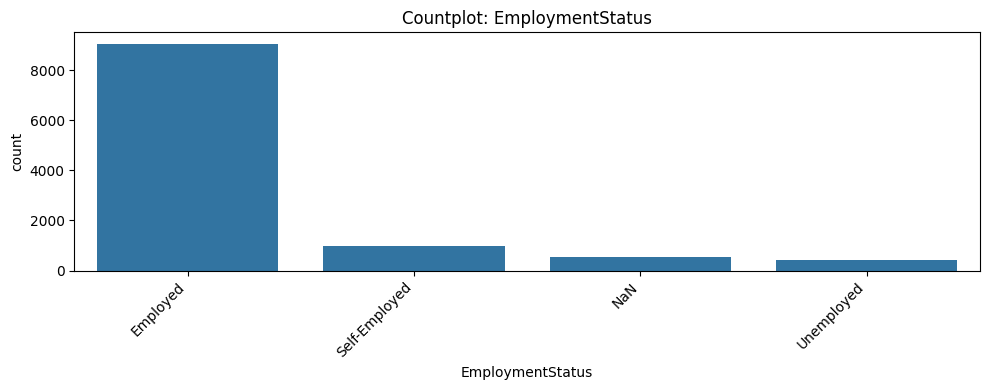

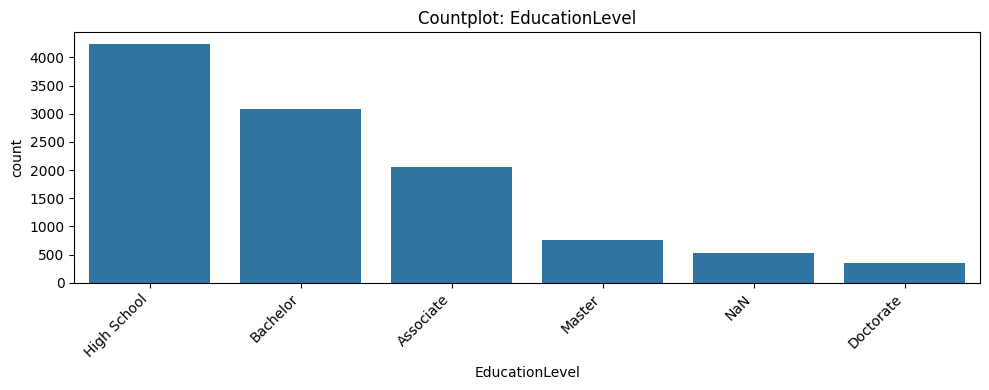

In [7]:
# %%
# EDA: categorical countplots

if sns is None:
    print("seaborn not available; skipping countplots.")
else:
    for c in cat_cols:
        if c not in X.columns:
            continue
        plt.figure(figsize=(10, 4))
        sns.countplot(
            data=pd.DataFrame({c: X[c].astype("object").fillna("NaN")}),
            x=c,
            order=pd.Series(X[c].astype("object").fillna("NaN")).value_counts().index
        )
        plt.title(f"Countplot: {c}")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


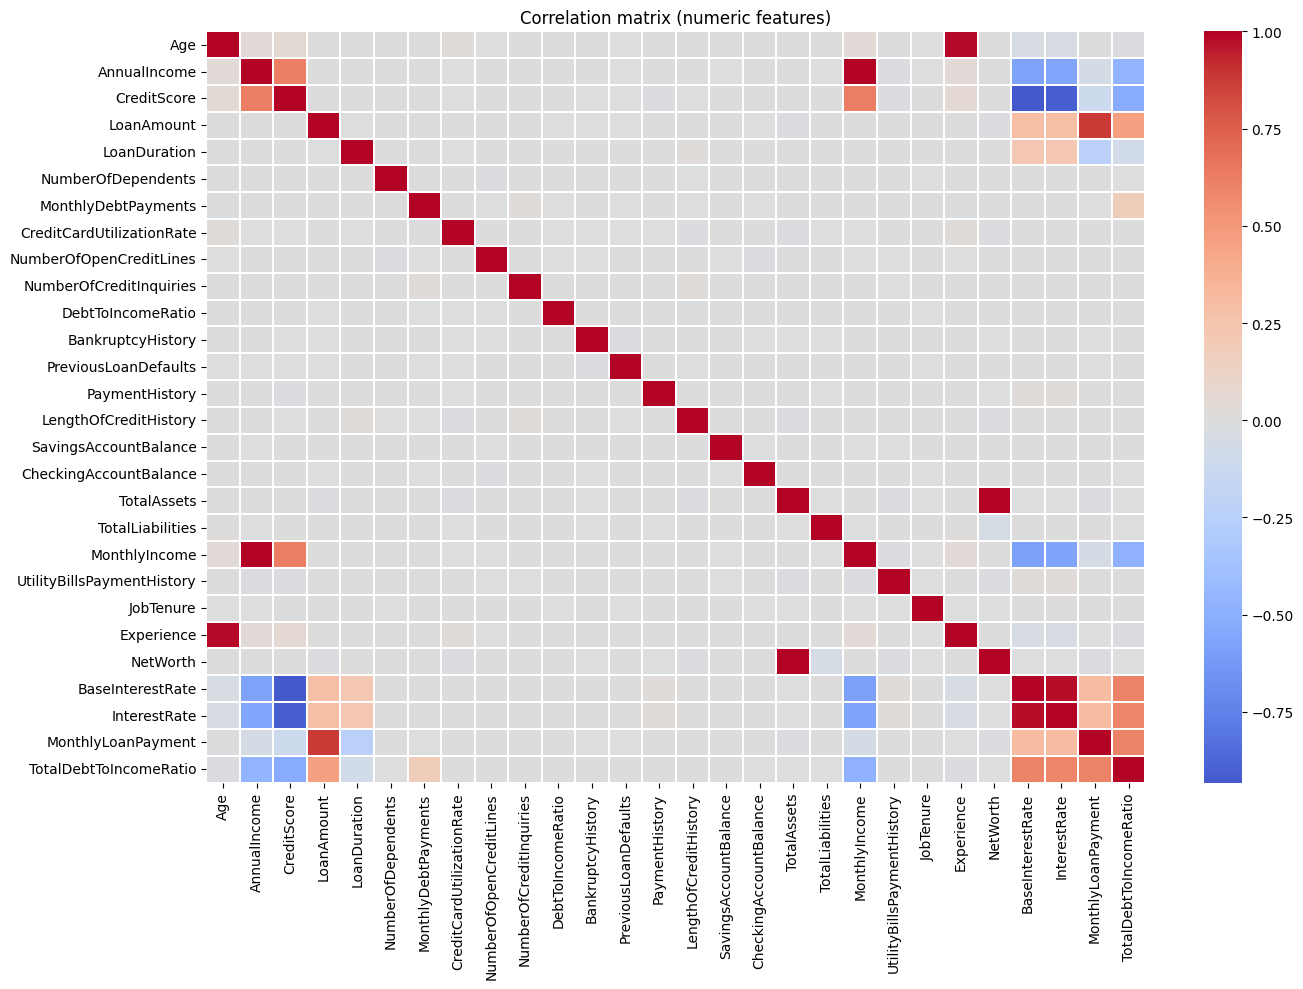

In [8]:
# %%
# EDA: correlation matrix (numeric only, from raw X)

num_df = X[num_cols].copy()
# Coerce to numeric
for c in num_df.columns:
    num_df[c] = pd.to_numeric(num_df[c], errors="coerce")

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
if sns is not None:
    sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.2)
else:
    plt.imshow(corr.values)
    plt.colorbar()
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()


In [9]:
# %%
# Custom: Date feature engineering transformer (inside Pipeline)

class DateFeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="ApplicationDate", drop_original=True):
        self.date_col = date_col
        self.drop_original = drop_original
        self.added_cols_ = ["AppYear", "AppMonth", "AppDay", "AppDayOfWeek", "AppIsWeekend"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_out = X.copy()
        if self.date_col in X_out.columns:
            dt = pd.to_datetime(X_out[self.date_col], errors="coerce")
            X_out["AppYear"] = dt.dt.year
            X_out["AppMonth"] = dt.dt.month
            X_out["AppDay"] = dt.dt.day
            X_out["AppDayOfWeek"] = dt.dt.dayofweek
            X_out["AppIsWeekend"] = dt.dt.dayofweek.isin([5, 6]).astype(float)
            if self.drop_original:
                X_out = X_out.drop(columns=[self.date_col])
        else:
            # Ensure columns exist even if date column missing
            for c in self.added_cols_:
                if c not in X_out.columns:
                    X_out[c] = np.nan
        return X_out


In [10]:
# %%
# Build preprocessing (Pipeline + ColumnTransformer, no leakage)

# Recompute columns using DateFeatureBuilder output schema
# We'll build on the actual X dataframe columns
tmp_Xb = DateFeatureBuilder(date_col=date_col).fit_transform(X.head(50))

cat_cols_present = [c for c in cat_cols if c in tmp_Xb.columns]
# All others numeric
num_cols_present = [c for c in tmp_Xb.columns if c not in set(cat_cols_present)]

# Ensure date-derived numeric included
print("Categorical cols:", cat_cols_present)
print("Numeric cols (count):", len(num_cols_present))

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols_present),
        ("cat", categorical_pipe, cat_cols_present),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

def make_pipeline(model):
    return Pipeline(steps=[
        ("date_features", DateFeatureBuilder(date_col=date_col, drop_original=True)),
        ("preprocess", preprocess),
        ("model", model),
    ])


Categorical cols: ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
Numeric cols (count): 33


In [11]:
# %%
# "From scratch" metrics (and AUC/PR-AUC if possible) + checks vs sklearn

def _to_numpy(a):
    if isinstance(a, (pd.Series, pd.DataFrame)):
        return a.values
    return np.asarray(a)

def accuracy_manual(y_true, y_pred):
    y_true = _to_numpy(y_true).astype(int)
    y_pred = _to_numpy(y_pred).astype(int)
    return float((y_true == y_pred).mean())

def precision_manual(y_true, y_pred):
    y_true = _to_numpy(y_true).astype(int)
    y_pred = _to_numpy(y_pred).astype(int)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    return float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0

def recall_manual(y_true, y_pred):
    y_true = _to_numpy(y_true).astype(int)
    y_pred = _to_numpy(y_pred).astype(int)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    return float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0

def f1_manual(y_true, y_pred):
    p = precision_manual(y_true, y_pred)
    r = recall_manual(y_true, y_pred)
    return float(2 * p * r / (p + r)) if (p + r) > 0 else 0.0

def roc_auc_manual(y_true, y_score):
    """
    ROC-AUC via Mann–Whitney U (rank-based), supports ties with average ranks.
    """
    y_true = _to_numpy(y_true).astype(int)
    y_score = _to_numpy(y_score).astype(float)
    pos = (y_true == 1)
    neg = (y_true == 0)
    n_pos = int(pos.sum())
    n_neg = int(neg.sum())
    if n_pos == 0 or n_neg == 0:
        return np.nan

    # average ranks with ties
    order = np.argsort(y_score)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(y_score) + 1, dtype=float)

    # tie handling: average ranks among equal scores
    sorted_scores = y_score[order]
    i = 0
    while i < len(sorted_scores):
        j = i
        while j + 1 < len(sorted_scores) and sorted_scores[j + 1] == sorted_scores[i]:
            j += 1
        if j > i:
            avg_rank = ranks[order[i:j+1]].mean()
            ranks[order[i:j+1]] = avg_rank
        i = j + 1

    sum_ranks_pos = float(ranks[pos].sum())
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

def pr_auc_manual(y_true, y_score):
    """
    PR-AUC (Average Precision) computed by constructing precision-recall curve
    and integrating with step-wise interpolation (like sklearn average_precision_score).
    """
    y_true = _to_numpy(y_true).astype(int)
    y_score = _to_numpy(y_score).astype(float)
    n_pos = int((y_true == 1).sum())
    if n_pos == 0:
        return np.nan

    # sort by score desc
    order = np.argsort(-y_score)
    y_sorted = y_true[order]

    tp = 0
    fp = 0
    precisions = []
    recalls = []

    for i in range(len(y_sorted)):
        if y_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / n_pos
        precisions.append(prec)
        recalls.append(rec)

    precisions = np.asarray(precisions, dtype=float)
    recalls = np.asarray(recalls, dtype=float)

    # Average Precision: sum over recall increases of precision at that point
    # Add (0,1) start
    prev_rec = 0.0
    ap = 0.0
    for p, r in zip(precisions, recalls):
        if r > prev_rec:
            ap += p * (r - prev_rec)
            prev_rec = r
    return float(ap)

# Quick sanity check on a toy example
yt = np.array([0, 0, 1, 1, 1])
ys = np.array([0.1, 0.4, 0.35, 0.8, 0.9])
sk_auc = roc_auc_score(yt, ys)
my_auc = roc_auc_manual(yt, ys)
sk_ap = average_precision_score(yt, ys)
my_ap = pr_auc_manual(yt, ys)
print("Toy ROC-AUC sklearn vs manual:", sk_auc, my_auc)
print("Toy PR-AUC  sklearn vs manual:", sk_ap, my_ap)


Toy ROC-AUC sklearn vs manual: 0.8333333333333333 0.8333333333333334
Toy PR-AUC  sklearn vs manual: 0.9166666666666665 0.9166666666666666


In [12]:
# %%
# Custom models "from scratch": MyBaggingClassifier + MyGradientBoostingClassifier

class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=25, max_samples=1.0, bootstrap=True, random_state=SEED):
        self.base_estimator = base_estimator
        self.n_estimators = int(n_estimators)
        self.max_samples = float(max_samples)
        self.bootstrap = bool(bootstrap)
        self.random_state = int(random_state)

    def fit(self, X, y):
        X = _to_numpy(X)
        y = _to_numpy(y).astype(int)

        rng = np.random.RandomState(self.random_state)
        n = X.shape[0]
        m = int(np.ceil(self.max_samples * n))
        m = max(1, min(m, n))

        if self.base_estimator is None:
            # Strong enough default
            self.base_estimator_ = LogisticRegression(
                max_iter=2000, solver="lbfgs", n_jobs=None, random_state=self.random_state
            )
        else:
            self.base_estimator_ = self.base_estimator

        self.estimators_ = []
        for i in range(self.n_estimators):
            est = clone(self.base_estimator_)
            if self.bootstrap:
                idx = rng.randint(0, n, size=m)
            else:
                idx = rng.choice(np.arange(n), size=m, replace=False)
            est.fit(X[idx], y[idx])
            self.estimators_.append(est)

        self.classes_ = np.array([0, 1], dtype=int)
        return self

    def predict_proba(self, X):
        X = _to_numpy(X)
        probs = []
        for est in self.estimators_:
            if hasattr(est, "predict_proba"):
                p = est.predict_proba(X)
                # ensure [:,1] exists
                if p.shape[1] == 2:
                    probs.append(p[:, 1])
                else:
                    probs.append(p.ravel())
            else:
                # fallback: use predict as hard vote
                probs.append(est.predict(X).astype(float))
        avg_p1 = np.mean(np.vstack(probs), axis=0)
        avg_p1 = np.clip(avg_p1, 1e-9, 1 - 1e-9)
        return np.vstack([1 - avg_p1, avg_p1]).T

    def predict(self, X):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= 0.5).astype(int)


class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    """
    Gradient Boosting for binary classification with logistic loss.
    Fits regressor base learners to pseudo-residuals: r = y - sigmoid(F).
    Updates logit scores: F <- F + lr * h(x).
    """
    def __init__(self, n_estimators=200, learning_rate=0.05, max_depth=2, min_samples_leaf=20, random_state=SEED):
        self.n_estimators = int(n_estimators)
        self.learning_rate = float(learning_rate)
        self.max_depth = int(max_depth)
        self.min_samples_leaf = int(min_samples_leaf)
        self.random_state = int(random_state)

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -35, 35)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = _to_numpy(X)
        y = _to_numpy(y).astype(int)

        rng = np.random.RandomState(self.random_state)
        self.estimators_ = []

        # init with log-odds
        p0 = np.clip(y.mean(), 1e-6, 1 - 1e-6)
        self.init_logit_ = float(np.log(p0 / (1 - p0)))

        F = np.full(shape=(X.shape[0],), fill_value=self.init_logit_, dtype=float)

        for t in range(self.n_estimators):
            p = self._sigmoid(F)
            residual = (y - p)  # negative gradient of log-loss wrt F

            base = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=int(rng.randint(0, 10_000_000))
            )
            base.fit(X, residual)
            update = base.predict(X)

            F += self.learning_rate * update
            self.estimators_.append(base)

        self.classes_ = np.array([0, 1], dtype=int)
        return self

    def decision_function(self, X):
        X = _to_numpy(X)
        F = np.full(shape=(X.shape[0],), fill_value=self.init_logit_, dtype=float)
        for est in self.estimators_:
            F += self.learning_rate * est.predict(X)
        return F

    def predict_proba(self, X):
        F = self.decision_function(X)
        p1 = self._sigmoid(F)
        p1 = np.clip(p1, 1e-9, 1 - 1e-9)
        return np.vstack([1 - p1, p1]).T

    def predict(self, X):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= 0.5).astype(int)


In [13]:
# %%
# CV evaluation utilities + OOF predictions + metrics table

def evaluate_oof(y_true, y_proba, threshold=0.5):
    y_true = _to_numpy(y_true).astype(int)
    y_proba = _to_numpy(y_proba).astype(float)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "ROC_AUC_sklearn": roc_auc_score(y_true, y_proba),
        "PR_AUC_sklearn": average_precision_score(y_true, y_proba),
        "Accuracy_sklearn": accuracy_score(y_true, y_pred),
        "Precision_sklearn": precision_score(y_true, y_pred, zero_division=0),
        "Recall_sklearn": recall_score(y_true, y_pred, zero_division=0),
        "F1_sklearn": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC_manual": roc_auc_manual(y_true, y_proba),
        "PR_AUC_manual": pr_auc_manual(y_true, y_proba),
        "Accuracy_manual": accuracy_manual(y_true, y_pred),
        "Precision_manual": precision_manual(y_true, y_pred),
        "Recall_manual": recall_manual(y_true, y_pred),
        "F1_manual": f1_manual(y_true, y_pred),
    }
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

def cv_oof_predict_proba(pipe, X_df, y_arr, n_splits=5, seed=SEED, verbose=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(y_arr), dtype=float)
    fold_aucs = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_df, y_arr), 1):
        X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
        y_tr, y_va = y_arr[tr_idx], y_arr[va_idx]

        model = clone(pipe)
        model.fit(X_tr, y_tr)
        p_va = model.predict_proba(X_va)[:, 1]
        oof[va_idx] = p_va

        auc = roc_auc_score(y_va, p_va)
        fold_aucs.append(auc)
        if verbose:
            print(f"Fold {fold}: ROC-AUC={auc:.5f}")

    fold_aucs = np.array(fold_aucs, dtype=float)
    if verbose:
        print(f"CV ROC-AUC mean±std: {fold_aucs.mean():.5f} ± {fold_aucs.std(ddof=1):.5f}")
    return oof, fold_aucs


In [14]:
# %%
# Define models to compare (with pipelines)

models = {}

# Baseline Logistic Regression (interpretable)
models["LogReg"] = make_pipeline(
    LogisticRegression(
        max_iter=5000,
        solver="lbfgs",
        random_state=SEED,
        class_weight="balanced"
    )
)

# MyBaggingClassifier (on top of preprocessed features)
models["MyBagging(LogReg)"] = make_pipeline(
    MyBaggingClassifier(
        base_estimator=LogisticRegression(
            max_iter=3000, solver="lbfgs", random_state=SEED, class_weight="balanced"
        ),
        n_estimators=35,
        max_samples=0.85,
        bootstrap=True,
        random_state=SEED
    )
)

# RandomForest / ExtraTrees (optional)
models["RandomForest"] = make_pipeline(
    RandomForestClassifier(
        n_estimators=600,
        random_state=SEED,
        class_weight="balanced_subsample",
        n_jobs=-1,
        max_depth=None,
        min_samples_leaf=2
    )
)

models["ExtraTrees"] = make_pipeline(
    ExtraTreesClassifier(
        n_estimators=800,
        random_state=SEED,
        class_weight="balanced",
        n_jobs=-1,
        max_depth=None,
        min_samples_leaf=2
    )
)

# sklearn GradientBoostingClassifier
models["SklearnGBC"] = make_pipeline(
    GradientBoostingClassifier(
        random_state=SEED,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=2
    )
)

# MyGradientBoostingClassifier (from scratch)
models["MyGBC"] = make_pipeline(
    MyGradientBoostingClassifier(
        n_estimators=350,
        learning_rate=0.05,
        max_depth=2,
        min_samples_leaf=25,
        random_state=SEED
    )
)

# XGBoost / LightGBM / CatBoost if available
if HAS_XGB:
    models["XGBoost"] = make_pipeline(
        xgb.XGBClassifier(
            random_state=SEED,
            n_estimators=1200,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=1.0,
            min_child_weight=2.0,
            eval_metric="auc",
            n_jobs=-1
        )
    )
else:
    print("xgboost not available -> skipping XGBoost")

if HAS_LGBM:
    models["LightGBM"] = make_pipeline(
        lgb.LGBMClassifier(
            random_state=SEED,
            n_estimators=2000,
            learning_rate=0.02,
            num_leaves=31,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=0.0,
            n_jobs=-1
        )
    )
else:
    print("lightgbm not available -> skipping LightGBM")

if HAS_CAT:
    models["CatBoost"] = make_pipeline(
        CatBoostClassifier(
            random_state=SEED,
            iterations=2500,
            learning_rate=0.02,
            depth=6,
            loss_function="Logloss",
            eval_metric="AUC",
            verbose=False
        )
    )
else:
    print("catboost not available -> skipping CatBoost")

print("Models:", list(models.keys()))


catboost not available -> skipping CatBoost
Models: ['LogReg', 'MyBagging(LogReg)', 'RandomForest', 'ExtraTrees', 'SklearnGBC', 'MyGBC', 'XGBoost', 'LightGBM']


In [15]:
# %%
# Run CV for each model, compute OOF metrics at threshold=0.5, collect results

results = []
oof_store = {}
auc_store = {}

N_SPLITS = 5

for name, pipe in models.items():
    print("\n" + "=" * 90)
    print("Model:", name)

    oof, fold_aucs = cv_oof_predict_proba(pipe, X, y, n_splits=N_SPLITS, seed=SEED, verbose=True)
    oof_store[name] = oof
    auc_store[name] = fold_aucs

    m, cm = evaluate_oof(y, oof, threshold=0.5)

    row = {
        "model": name,
        "CV_ROC_AUC_mean": float(np.mean(fold_aucs)),
        "CV_ROC_AUC_std": float(np.std(fold_aucs, ddof=1)),
        "OOF_PR_AUC": m["PR_AUC_sklearn"],
        "OOF_F1@0.5": m["F1_sklearn"],
        "OOF_Accuracy@0.5": m["Accuracy_sklearn"],
        "OOF_Precision@0.5": m["Precision_sklearn"],
        "OOF_Recall@0.5": m["Recall_sklearn"],
    }
    results.append(row)

results_df = pd.DataFrame(results).sort_values(by="CV_ROC_AUC_mean", ascending=False).reset_index(drop=True)
display(results_df)



Model: LogReg
Fold 1: ROC-AUC=0.98180
Fold 2: ROC-AUC=0.98445
Fold 3: ROC-AUC=0.98137
Fold 4: ROC-AUC=0.98679
Fold 5: ROC-AUC=0.98791
CV ROC-AUC mean±std: 0.98447 ± 0.00291

Model: MyBagging(LogReg)
Fold 1: ROC-AUC=0.98166
Fold 2: ROC-AUC=0.98441
Fold 3: ROC-AUC=0.98147
Fold 4: ROC-AUC=0.98689
Fold 5: ROC-AUC=0.98756
CV ROC-AUC mean±std: 0.98440 ± 0.00284

Model: RandomForest
Fold 1: ROC-AUC=0.98074
Fold 2: ROC-AUC=0.98095
Fold 3: ROC-AUC=0.98243
Fold 4: ROC-AUC=0.98586
Fold 5: ROC-AUC=0.98503
CV ROC-AUC mean±std: 0.98300 ± 0.00234

Model: ExtraTrees
Fold 1: ROC-AUC=0.98076
Fold 2: ROC-AUC=0.98168
Fold 3: ROC-AUC=0.98218
Fold 4: ROC-AUC=0.98335
Fold 5: ROC-AUC=0.98265
CV ROC-AUC mean±std: 0.98212 ± 0.00098

Model: SklearnGBC
Fold 1: ROC-AUC=0.98197
Fold 2: ROC-AUC=0.98249
Fold 3: ROC-AUC=0.98256
Fold 4: ROC-AUC=0.98760
Fold 5: ROC-AUC=0.98799
CV ROC-AUC mean±std: 0.98452 ± 0.00300

Model: MyGBC
Fold 1: ROC-AUC=0.96976
Fold 2: ROC-AUC=0.97161
Fold 3: ROC-AUC=0.97325
Fold 4: ROC-AUC=0.9

,model,CV_ROC_AUC_mean,CV_ROC_AUC_std,OOF_PR_AUC,OOF_F1@0.5,OOF_Accuracy@0.5,OOF_Precision@0.5,OOF_Recall@0.5
0,LightGBM,0.986567,0.002220,0.986208,0.935679,0.937279,0.934896,0.936464
1,XGBoost,0.986190,0.002377,0.985897,0.933507,0.935191,0.933160,0.933855
2,SklearnGBC,0.984520,0.003001,0.984473,0.930189,0.932014,0.930623,0.929756
3,LogReg,0.984467,0.002914,0.984954,0.931522,0.933648,0.936699,0.926402
4,MyBagging(LogReg),0.984398,0.002839,0.984907,0.931597,0.933739,0.937041,0.926216
5,RandomForest,0.983000,0.002341,0.982045,0.930033,0.931742,0.928824,0.931247
6,ExtraTrees,0.982125,0.000980,0.981966,0.924930,0.927022,0.927007,0.922862
7,MyGBC,0.974397,0.004292,0.974094,0.910165,0.913043,0.916179,0.904230


In [16]:
# %%
# Choose best model by CV ROC-AUC mean

best_model_name = results_df.loc[0, "model"]
best_pipe = models[best_model_name]
best_oof = oof_store[best_model_name]

print("Best model:", best_model_name)
print("Best CV ROC-AUC mean±std:", results_df.loc[0, "CV_ROC_AUC_mean"], "±", results_df.loc[0, "CV_ROC_AUC_std"])


Best model: LightGBM
Best CV ROC-AUC mean±std: 0.9865665089552929 ± 0.0022198896792027644


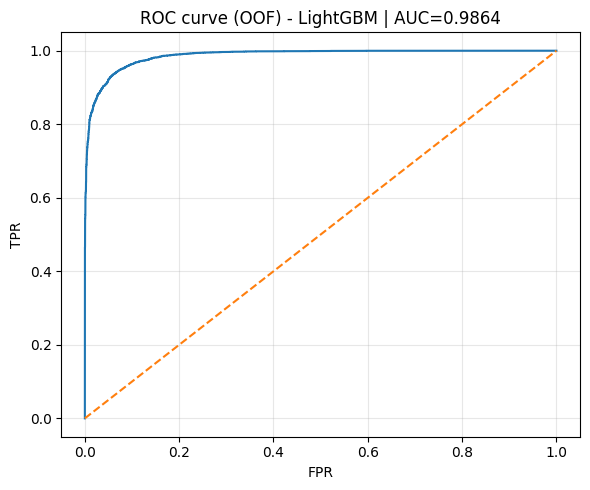

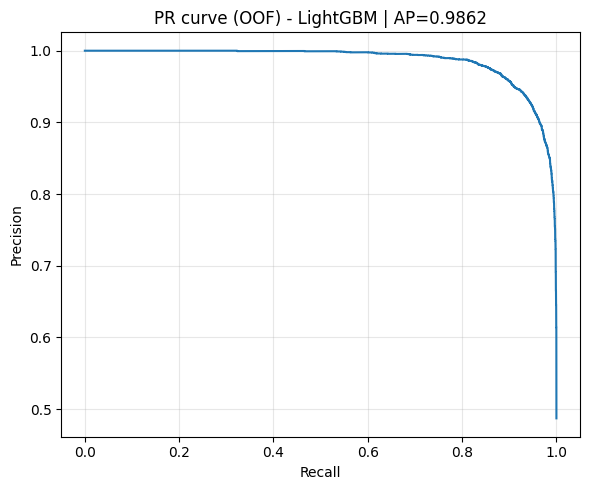

In [17]:
# %%
# Plot ROC / PR curves for the best model (OOF)

fpr, tpr, _ = roc_curve(y, best_oof)
prec, rec, _ = precision_recall_curve(y, best_oof)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (OOF) - {best_model_name} | AUC={roc_auc_score(y, best_oof):.4f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f"PR curve (OOF) - {best_model_name} | AP={average_precision_score(y, best_oof):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Best threshold by OOF F1: 0.38
Best OOF F1: 0.9361387966039129


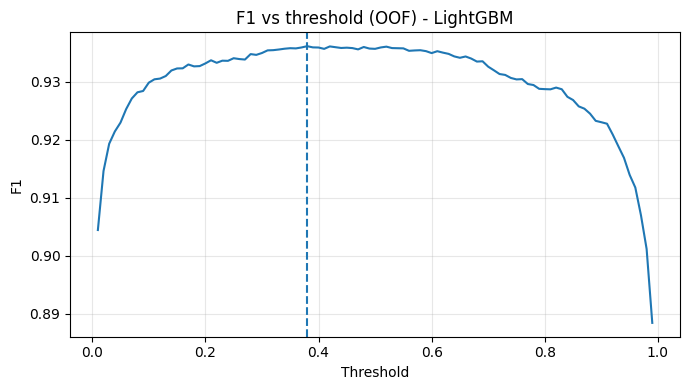

Metrics @ best threshold:


,0
Accuracy_manual,0.937188
Accuracy_sklearn,0.937188
F1_manual,0.936139
F1_sklearn,0.936139
PR_AUC_manual,0.986208
PR_AUC_sklearn,0.986208
Precision_manual,0.927409
Precision_sklearn,0.927409
ROC_AUC_manual,0.986404
ROC_AUC_sklearn,0.986404



Confusion matrix @ best threshold:


,pred_0,pred_1
true_0,5253,397
true_1,295,5072


In [18]:
# %%
# Threshold tuning on OOF: maximize F1 (can change criterion here if needed)

thresholds = np.linspace(0.01, 0.99, 99)
f1s = []
for th in thresholds:
    y_pred = (best_oof >= th).astype(int)
    f1s.append(f1_score(y, y_pred, zero_division=0))

f1s = np.array(f1s)
best_th = float(thresholds[np.argmax(f1s)])

print("Best threshold by OOF F1:", best_th)
print("Best OOF F1:", float(np.max(f1s)))

plt.figure(figsize=(7, 4))
plt.plot(thresholds, f1s)
plt.axvline(best_th, linestyle="--")
plt.title(f"F1 vs threshold (OOF) - {best_model_name}")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

m_best, cm_best = evaluate_oof(y, best_oof, threshold=best_th)
print("Metrics @ best threshold:")
display(pd.Series(m_best).sort_index())
print("\nConfusion matrix @ best threshold:")
display(pd.DataFrame(cm_best, index=["true_0", "true_1"], columns=["pred_0", "pred_1"]))


[LightGBM] [Info] Number of positive: 5367, number of negative: 5650
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4702
[LightGBM] [Info] Number of data points in the train set: 11017, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487156 -> initscore=-0.051386
[LightGBM] [Info] Start training from score -0.051386
Top feature_importances_:


,feature,importance
27,TotalDebtToIncomeRatio,4174.0
25,InterestRate,3590.0
23,NetWorth,2963.0
17,TotalAssets,2736.0
3,LoanAmount,2341.0
15,SavingsAccountBalance,2323.0
16,CheckingAccountBalance,2313.0
20,UtilityBillsPaymentHistory,2298.0
1,AnnualIncome,2258.0
6,MonthlyDebtPayments,2229.0


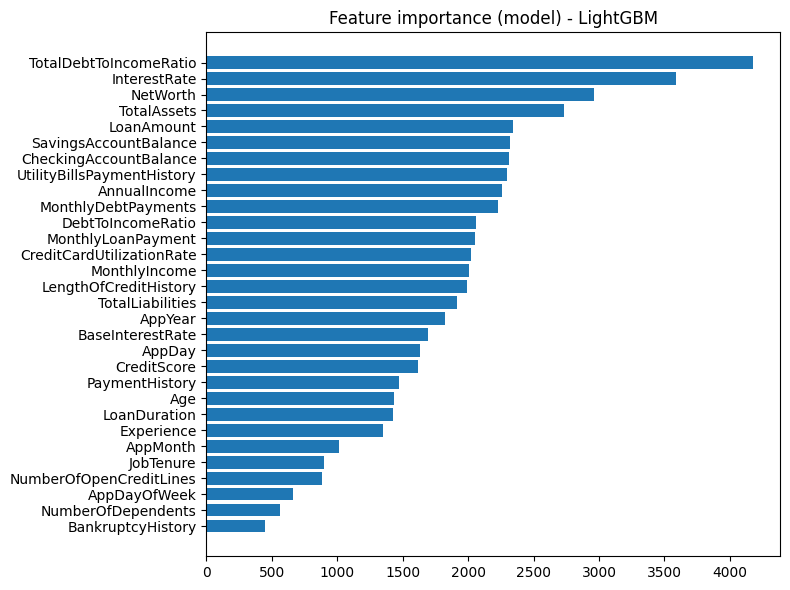

[LightGBM] [Info] Number of positive: 4293, number of negative: 4520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4695
[LightGBM] [Info] Number of data points in the train set: 8813, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487121 -> initscore=-0.051526
[LightGBM] [Info] Start training from score -0.051526
Permutation importance failed: ValueError('All arrays must be of the same length')


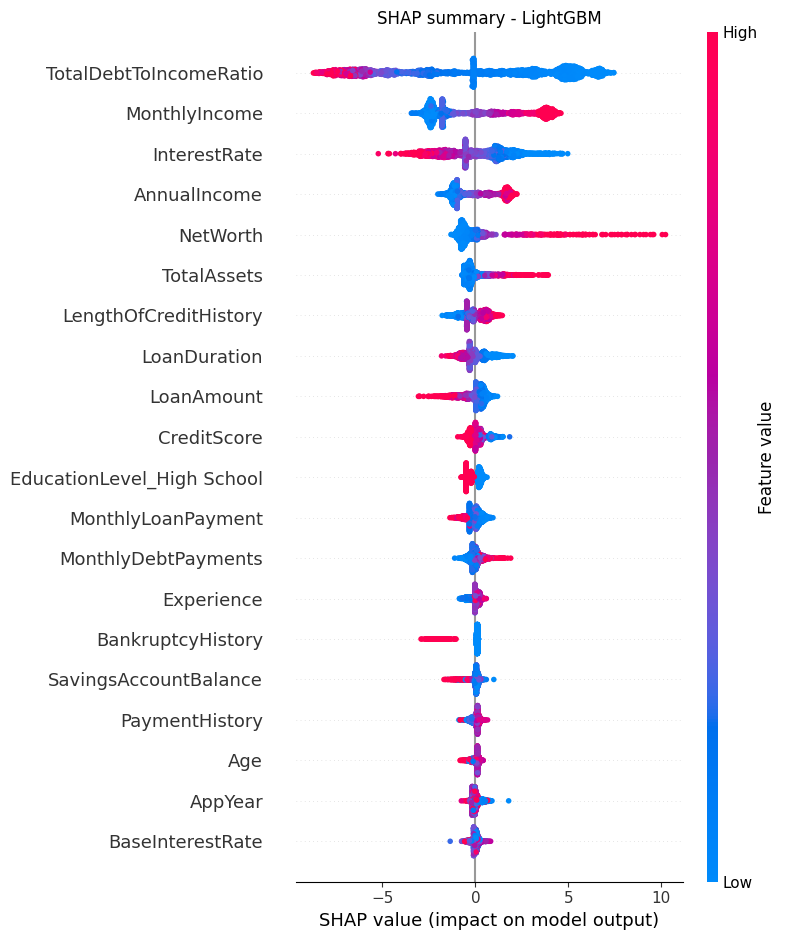

In [19]:
# %%
# Fit best model on full train, then interpret (LogReg coefficients / feature importance / permutation / SHAP)

best_pipe_full = clone(best_pipe).fit(X, y)

# Helper: get feature names after preprocess
def get_feature_names(fitted_pipe: Pipeline):
    prep = fitted_pipe.named_steps["preprocess"]
    # Works for sklearn >= 1.0
    try:
        return prep.get_feature_names_out()
    except Exception:
        # Fallback (best effort)
        names = []
        # numeric names
        names.extend([f"num__{c}" for c in num_cols_present])
        # cat ohe names unknown here
        return np.array(names, dtype=object)

feature_names = get_feature_names(best_pipe_full)
model_step = best_pipe_full.named_steps["model"]

# Logistic regression coefficients
if isinstance(model_step, LogisticRegression):
    coef = model_step.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).head(30)
    print("Top LogReg coefficients (abs):")
    display(coef_df)

# Tree-based feature importances (if available)
if hasattr(model_step, "feature_importances_"):
    fi = np.asarray(model_step.feature_importances_, dtype=float)
    fi_df = pd.DataFrame({"feature": feature_names, "importance": fi})
    fi_df = fi_df.sort_values("importance", ascending=False).head(30)
    print("Top feature_importances_:")
    display(fi_df)

    plt.figure(figsize=(8, 6))
    plt.barh(fi_df["feature"][::-1], fi_df["importance"][::-1])
    plt.title(f"Feature importance (model) - {best_model_name}")
    plt.tight_layout()
    plt.show()

# Permutation importance (on a stratified holdout split from train to keep it fast)
from sklearn.model_selection import train_test_split
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

perm_model = clone(best_pipe).fit(X_tr, y_tr)
try:
    r = permutation_importance(
        perm_model, X_va, y_va,
        scoring="roc_auc",
        n_repeats=7,
        random_state=SEED,
        n_jobs=-1
    )
    perm_df = pd.DataFrame({
        "feature": get_feature_names(perm_model),
        "perm_importance_mean": r.importances_mean,
        "perm_importance_std": r.importances_std
    }).sort_values("perm_importance_mean", ascending=False).head(30)

    print("Top permutation importance (ROC-AUC):")
    display(perm_df)

    plt.figure(figsize=(8, 6))
    plt.barh(perm_df["feature"][::-1], perm_df["perm_importance_mean"][::-1])
    plt.title(f"Permutation importance (ROC-AUC) - {best_model_name}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance failed:", repr(e))

# SHAP (if available)
if HAS_SHAP:
    try:
        # Transform once for SHAP
        X_va_trans = perm_model.named_steps["preprocess"].transform(
            perm_model.named_steps["date_features"].transform(X_va)
        )
        fn = get_feature_names(perm_model)

        if hasattr(model_step, "predict_proba") and hasattr(model_step, "feature_importances_"):
            explainer = shap.TreeExplainer(model_step)
            shap_values = explainer.shap_values(X_va_trans)
            # For binary, shap_values could be list; take class 1 if list
            sv = shap_values[1] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(sv, features=X_va_trans, feature_names=fn, show=False)
            plt.title(f"SHAP summary - {best_model_name}")
            plt.tight_layout()
            plt.show()
        elif isinstance(model_step, LogisticRegression):
            explainer = shap.LinearExplainer(model_step, X_va_trans, feature_perturbation="interventional")
            sv = explainer.shap_values(X_va_trans)
            shap.summary_plot(sv, features=X_va_trans, feature_names=fn, show=False)
            plt.title(f"SHAP summary (Linear) - {best_model_name}")
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP available but model type not supported for this SHAP snippet.")
    except Exception as e:
        print("SHAP failed:", repr(e))
else:
    print("shap not available -> skipping SHAP")


In [20]:
# %%
# Optuna hyperparameter search for the best "family" (skips if optuna unavailable)
# Optimizes CV ROC-AUC.

def optuna_search_for_model(model_name, base_pipe, X_df, y_arr, n_splits=5, n_trials=75, timeout_sec=600):
    if not HAS_OPTUNA:
        print("optuna not available -> skipping Optuna search.")
        return None

    # Decide search space based on model
    def objective(trial):
        # Build model with trial params
        if model_name in ["LogReg", "MyBagging(LogReg)"]:
            C = trial.suggest_float("C", 1e-3, 50.0, log=True)
            if model_name == "LogReg":
                model = LogisticRegression(
                    max_iter=6000, solver="lbfgs", random_state=SEED, class_weight="balanced", C=C
                )
            else:
                n_estimators = trial.suggest_int("n_estimators", 15, 80)
                max_samples = trial.suggest_float("max_samples", 0.6, 1.0)
                model = MyBaggingClassifier(
                    base_estimator=LogisticRegression(
                        max_iter=4000, solver="lbfgs", random_state=SEED, class_weight="balanced", C=C
                    ),
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    bootstrap=True,
                    random_state=SEED
                )
            pipe = make_pipeline(model)

        elif model_name in ["RandomForest", "ExtraTrees"]:
            n_estimators = trial.suggest_int("n_estimators", 300, 1200)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
            max_depth = trial.suggest_int("max_depth", 3, 40)

            if model_name == "RandomForest":
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    random_state=SEED,
                    class_weight="balanced_subsample",
                    n_jobs=-1,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf
                )
            else:
                model = ExtraTreesClassifier(
                    n_estimators=n_estimators,
                    random_state=SEED,
                    class_weight="balanced",
                    n_jobs=-1,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf
                )
            pipe = make_pipeline(model)

        elif model_name in ["SklearnGBC", "MyGBC"]:
            n_estimators = trial.suggest_int("n_estimators", 150, 800)
            lr = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
            max_depth = trial.suggest_int("max_depth", 1, 4)

            if model_name == "SklearnGBC":
                model = GradientBoostingClassifier(
                    random_state=SEED,
                    n_estimators=n_estimators,
                    learning_rate=lr,
                    max_depth=max_depth
                )
            else:
                min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 80)
                model = MyGradientBoostingClassifier(
                    n_estimators=n_estimators,
                    learning_rate=lr,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=SEED
                )
            pipe = make_pipeline(model)

        elif model_name == "XGBoost" and HAS_XGB:
            n_estimators = trial.suggest_int("n_estimators", 400, 2500)
            lr = trial.suggest_float("learning_rate", 0.01, 0.15, log=True)
            max_depth = trial.suggest_int("max_depth", 3, 7)
            subsample = trial.suggest_float("subsample", 0.6, 1.0)
            colsample = trial.suggest_float("colsample_bytree", 0.6, 1.0)
            reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True)
            min_child_weight = trial.suggest_float("min_child_weight", 1.0, 10.0)

            model = xgb.XGBClassifier(
                random_state=SEED,
                n_estimators=n_estimators,
                learning_rate=lr,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample,
                reg_lambda=reg_lambda,
                min_child_weight=min_child_weight,
                eval_metric="auc",
                n_jobs=-1
            )
            pipe = make_pipeline(model)

        elif model_name == "LightGBM" and HAS_LGBM:
            n_estimators = trial.suggest_int("n_estimators", 600, 4000)
            lr = trial.suggest_float("learning_rate", 0.005, 0.1, log=True)
            num_leaves = trial.suggest_int("num_leaves", 16, 128)
            subsample = trial.suggest_float("subsample", 0.6, 1.0)
            colsample = trial.suggest_float("colsample_bytree", 0.6, 1.0)

            model = lgb.LGBMClassifier(
                random_state=SEED,
                n_estimators=n_estimators,
                learning_rate=lr,
                num_leaves=num_leaves,
                subsample=subsample,
                colsample_bytree=colsample,
                n_jobs=-1
            )
            pipe = make_pipeline(model)

        elif model_name == "CatBoost" and HAS_CAT:
            depth = trial.suggest_int("depth", 4, 10)
            lr = trial.suggest_float("learning_rate", 0.005, 0.2, log=True)
            iterations = trial.suggest_int("iterations", 800, 4000)
            l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 20.0)

            model = CatBoostClassifier(
                random_state=SEED,
                iterations=iterations,
                learning_rate=lr,
                depth=depth,
                l2_leaf_reg=l2_leaf_reg,
                loss_function="Logloss",
                eval_metric="AUC",
                verbose=False
            )
            pipe = make_pipeline(model)
        else:
            # If no search defined, return baseline CV
            return results_df[results_df["model"] == model_name]["CV_ROC_AUC_mean"].iloc[0]

        # CV ROC-AUC
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        aucs = []
        for tr_idx, va_idx in skf.split(X_df, y_arr):
            X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            y_tr, y_va = y_arr[tr_idx], y_arr[va_idx]
            p = clone(pipe).fit(X_tr, y_tr).predict_proba(X_va)[:, 1]
            aucs.append(roc_auc_score(y_va, p))
        return float(np.mean(aucs))

    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, timeout=timeout_sec, show_progress_bar=False)

    print("Optuna best value:", study.best_value)
    print("Optuna best params:", study.best_params)
    return study

study = optuna_search_for_model(best_model_name, best_pipe, X, y, n_splits=N_SPLITS, n_trials=80, timeout_sec=600)


optuna not available -> skipping Optuna search.


In [21]:
# %%
# Rebuild best model with Optuna params (if study exists), then recompute OOF + threshold

def build_model_from_params(model_name, params):
    if model_name == "LogReg":
        return make_pipeline(
            LogisticRegression(
                max_iter=6000, solver="lbfgs", random_state=SEED, class_weight="balanced",
                C=float(params.get("C", 1.0))
            )
        )
    if model_name == "MyBagging(LogReg)":
        C = float(params.get("C", 1.0))
        n_estimators = int(params.get("n_estimators", 35))
        max_samples = float(params.get("max_samples", 0.85))
        return make_pipeline(
            MyBaggingClassifier(
                base_estimator=LogisticRegression(
                    max_iter=4000, solver="lbfgs", random_state=SEED, class_weight="balanced", C=C
                ),
                n_estimators=n_estimators,
                max_samples=max_samples,
                bootstrap=True,
                random_state=SEED
            )
        )
    if model_name == "RandomForest":
        return make_pipeline(
            RandomForestClassifier(
                n_estimators=int(params.get("n_estimators", 600)),
                random_state=SEED,
                class_weight="balanced_subsample",
                n_jobs=-1,
                max_depth=int(params.get("max_depth", 20)),
                min_samples_leaf=int(params.get("min_samples_leaf", 2)),
            )
        )
    if model_name == "ExtraTrees":
        return make_pipeline(
            ExtraTreesClassifier(
                n_estimators=int(params.get("n_estimators", 800)),
                random_state=SEED,
                class_weight="balanced",
                n_jobs=-1,
                max_depth=int(params.get("max_depth", 20)),
                min_samples_leaf=int(params.get("min_samples_leaf", 2)),
            )
        )
    if model_name == "SklearnGBC":
        return make_pipeline(
            GradientBoostingClassifier(
                random_state=SEED,
                n_estimators=int(params.get("n_estimators", 400)),
                learning_rate=float(params.get("learning_rate", 0.05)),
                max_depth=int(params.get("max_depth", 2)),
            )
        )
    if model_name == "MyGBC":
        return make_pipeline(
            MyGradientBoostingClassifier(
                n_estimators=int(params.get("n_estimators", 350)),
                learning_rate=float(params.get("learning_rate", 0.05)),
                max_depth=int(params.get("max_depth", 2)),
                min_samples_leaf=int(params.get("min_samples_leaf", 25)),
                random_state=SEED
            )
        )
    if model_name == "XGBoost" and HAS_XGB:
        return make_pipeline(
            xgb.XGBClassifier(
                random_state=SEED,
                n_estimators=int(params.get("n_estimators", 1200)),
                learning_rate=float(params.get("learning_rate", 0.03)),
                max_depth=int(params.get("max_depth", 4)),
                subsample=float(params.get("subsample", 0.85)),
                colsample_bytree=float(params.get("colsample_bytree", 0.85)),
                reg_lambda=float(params.get("reg_lambda", 1.0)),
                min_child_weight=float(params.get("min_child_weight", 2.0)),
                eval_metric="auc",
                n_jobs=-1
            )
        )
    if model_name == "LightGBM" and HAS_LGBM:
        return make_pipeline(
            lgb.LGBMClassifier(
                random_state=SEED,
                n_estimators=int(params.get("n_estimators", 2000)),
                learning_rate=float(params.get("learning_rate", 0.02)),
                num_leaves=int(params.get("num_leaves", 31)),
                subsample=float(params.get("subsample", 0.85)),
                colsample_bytree=float(params.get("colsample_bytree", 0.85)),
                n_jobs=-1
            )
        )
    if model_name == "CatBoost" and HAS_CAT:
        return make_pipeline(
            CatBoostClassifier(
                random_state=SEED,
                iterations=int(params.get("iterations", 2500)),
                learning_rate=float(params.get("learning_rate", 0.02)),
                depth=int(params.get("depth", 6)),
                l2_leaf_reg=float(params.get("l2_leaf_reg", 3.0)),
                loss_function="Logloss",
                eval_metric="AUC",
                verbose=False
            )
        )
    return models[model_name]

if study is not None:
    tuned_pipe = build_model_from_params(best_model_name, study.best_params)
    tuned_oof, tuned_fold_aucs = cv_oof_predict_proba(tuned_pipe, X, y, n_splits=N_SPLITS, seed=SEED, verbose=True)

    # Pick threshold by F1 on tuned OOF
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = np.array([f1_score(y, (tuned_oof >= th).astype(int), zero_division=0) for th in thresholds])
    tuned_th = float(thresholds[np.argmax(f1s)])

    print("Tuned best threshold:", tuned_th, "Tuned best OOF F1:", float(np.max(f1s)))

    m_tuned, cm_tuned = evaluate_oof(y, tuned_oof, threshold=tuned_th)
    display(pd.Series(m_tuned).sort_index())
    display(pd.DataFrame(cm_tuned, index=["true_0", "true_1"], columns=["pred_0", "pred_1"]))

    # Override best for final
    best_pipe = tuned_pipe
    best_model_name = best_model_name + " (tuned)"
    best_oof = tuned_oof
    best_th = tuned_th
else:
    print("No Optuna study -> keeping previous best.")


No Optuna study -> keeping previous best.


In [22]:
# %%
# Final fit on all train, predict on test, apply threshold -> submission.csv (0/1 only) + format checks

final_pipe = clone(best_pipe).fit(X, y)

test_ids = test_df[ID_COL].copy()
assert test_ids.isna().sum() == 0, "ID has NaN in test"
assert test_ids.nunique() == len(test_ids), "ID not unique in test"

test_proba = final_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_th).astype(int)

sub = pd.DataFrame({ID_COL: test_ids, TARGET: test_pred.astype(int)})

# Format checks
assert sub.shape[0] == test_df.shape[0], "Submission row count mismatch"
assert list(sub.columns) == [ID_COL, TARGET], "Submission columns mismatch"
assert sub[ID_COL].nunique() == sub.shape[0], "Submission ID not unique"
assert set(sub[TARGET].unique()).issubset({0, 1}), "Submission must be binary 0/1"

out_path = ROOT / "submission.csv"
sub.to_csv(out_path, index=False)

print("Saved:", out_path)
display(sub.head(10))
print("Submission target distribution:")
display(sub[TARGET].value_counts())


[LightGBM] [Info] Number of positive: 5367, number of negative: 5650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4702
[LightGBM] [Info] Number of data points in the train set: 11017, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487156 -> initscore=-0.051386
[LightGBM] [Info] Start training from score -0.051386
Saved: /content/submission.csv


,ID,LoanApproved
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,0


Submission target distribution:


,count
LoanApproved,
1,2645
0,2355


In [23]:
# %%
# Colab: установка Optuna (в текущий runtime)
!pip -q install -U optuna




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.9 MB/s eta 0:00:00


In [24]:
# %%
# Перезапусти runtime: Runtime -> Restart runtime (иначе иногда импорт "не видит" пакет)
# После рестарта проверь:
import optuna
print("Optuna version:", optuna.__version__)

Optuna version: 4.6.0
